In [1]:
import glob
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import statsmodels.formula.api as smf
import yaml

plt.style.use("ggplot")

# Explore NodeODM processing statistics

## 1. Read NodeODM logs

In [2]:
base_path = r"/home/notebook/shared-seabee-ns9879k/seabirds/2023"

In [3]:
search_path = os.path.join(base_path, r"*/*/report/log.json")
flist = glob.glob(search_path)

times_list = []
nfiles_list = []
st_date_list = []
end_date_list = []
for fpath in flist:
    with open(fpath) as f:
        data = json.load(f)

    times_list.append(data["totalTime"] / 60)
    nfiles_list.append(data["images"])
    st_date_list.append(data["startTime"])
    end_date_list.append(data["endTime"])

df = pd.DataFrame(
    {
        "nfiles": nfiles_list,
        "time_mins": times_list,
        "start_date": st_date_list,
        "end_date": end_date_list,
    }
)
df.head()

,nfiles,time_mins,start_date,end_date
0,33,43.068000,2023-06-05T11:51:31.656301,2023-06-05T12:34:35.740265
1,403,298.795167,2023-06-02T20:27:51.171463,2023-06-03T01:26:38.879138
2,28,17.765833,2023-05-26T15:06:58.913786,2023-05-26T15:24:44.861603
3,491,381.301167,2023-05-23T15:01:11.145422,2023-05-23T21:22:29.213322
4,1908,1766.104667,2023-05-28T22:09:44.901469,2023-05-30T03:35:51.178340


## 2. CDF of image counts

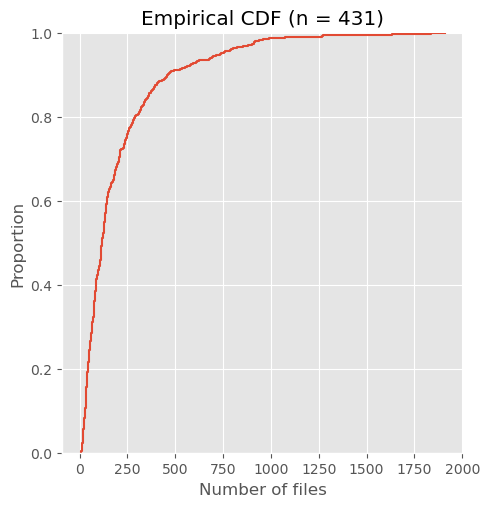

In [4]:
g = sn.displot(df["nfiles"], kind="ecdf")
g.set(xlabel="Number of files", title=f"Empirical CDF (n = {len(flist)})")

## 3. CDF of processing times

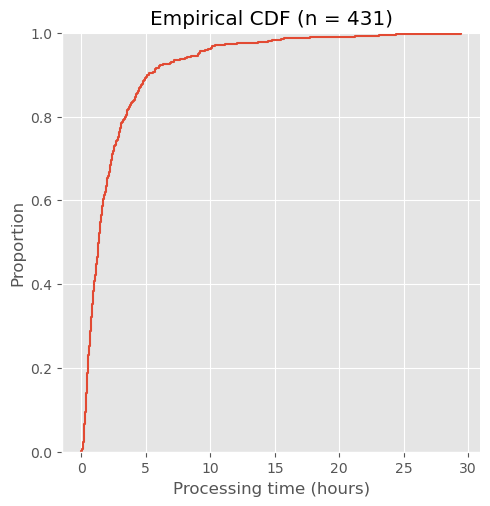

In [5]:
g = sn.displot(df["time_mins"] / 60, kind="ecdf")
g.set(xlabel="Processing time (hours)", title=f"Empirical CDF (n = {len(flist)})")

## 3. Relationship between number of images and processing time

                                 OLS Regression Results                                
Dep. Variable:              time_mins   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              6469.
Date:                Tue, 06 Jun 2023   Prob (F-statistic):                   2.85e-261
Time:                        14:01:33   Log-Likelihood:                         -2400.7
No. Observations:                 431   AIC:                                      4803.
Df Residuals:                     430   BIC:                                      4808.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0, 0.5, 'Processing time (mins)')

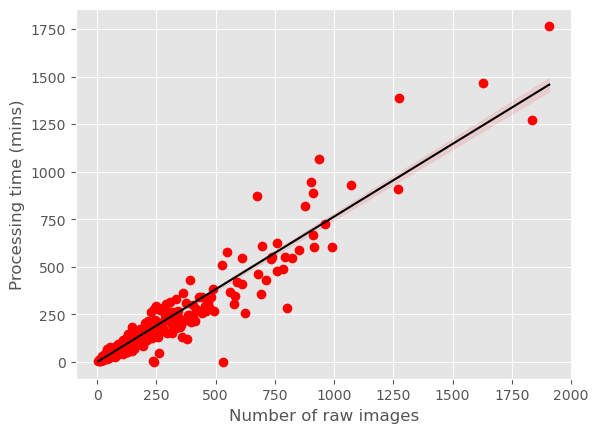

In [6]:
res = smf.ols(formula="time_mins ~ nfiles - 1", data=df).fit()
print(res.summary())
res_df = res.get_prediction().summary_frame()
res_df["nfiles"] = df["nfiles"]
res_df.sort_values("nfiles", inplace=True)

plt.plot(df["nfiles"], df["time_mins"], "ro")
plt.plot(res_df["nfiles"], res_df["mean"], "k-")
plt.fill_between(
    res_df["nfiles"],
    res_df["mean_ci_lower"],
    res_df["mean_ci_upper"],
    alpha=0.1,
    color="r",
)
plt.xlabel("Number of raw images")
plt.ylabel("Processing time (mins)")

## 4. Memory and CPU usage

array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

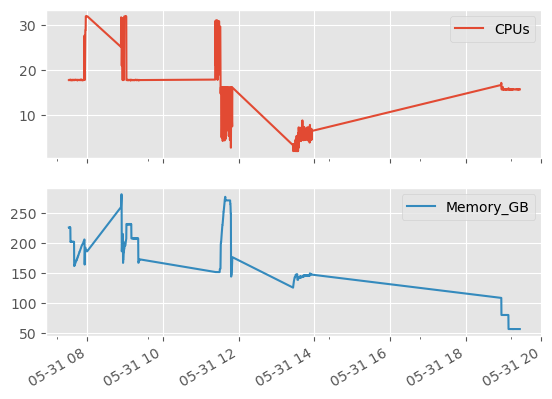

In [7]:
txt_path = r"/home/notebook/shared-seabee-ns9879k/notebook-logs/nodeodm-4missions-5249images-32cpu.txt"
log_df = pd.read_csv(
    txt_path,
    skiprows=2,
    header=None,
    names=["Name", "CPUs", "Memory_GB"],
    delim_whitespace=True,
)
log_df["CPUs"] = log_df["CPUs"].str.replace("m", "").astype(int) / 1000
log_df["Memory_GB"] = log_df["Memory_GB"].str.replace("Mi", "").astype(int) / 1000
del log_df["Name"]
log_df.index = pd.to_datetime(log_df.index)
log_df.plot(subplots=True)

## 5. Count of missions per day

In [8]:
for day in range(1, 16):
    search_path = f"/home/notebook/shared-seabee-ns9879k/seabirds/2023/Team1Dag{day}_*"
    flist = glob.glob(search_path)
    print(f"Team1Dag{day:02d}:", len(flist))

Team1Dag01: 19
Team1Dag02: 25
Team1Dag03: 14
Team1Dag04: 38
Team1Dag05: 16
Team1Dag06: 29
Team1Dag07: 25
Team1Dag08: 1
Team1Dag09: 15
Team1Dag10: 20
Team1Dag11: 18
Team1Dag12: 37
Team1Dag13: 6
Team1Dag14: 11
Team1Dag15: 23
